# Quora Insincere Questions Classification using TF IDF

## Download Data 

In [2]:
import os

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [5]:
!kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p data
!kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p data
!kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p data

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


## Import Data using Pandas

In [6]:
import pandas as pd

In [7]:
train_fname = 'data/train.csv.zip'
test_fname = 'data/test.csv.zip'
sample_fname = 'data/sample_submission.csv.zip'

In [84]:
raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)
sub_df = pd.read_csv(sample_fname)

In [9]:
raw_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [10]:
raw_df['target'].unique()

array([0, 1], dtype=int64)

In [15]:
sincere_df = raw_df[raw_df['target'] == 0]
insincere_df = raw_df[raw_df['target'] == 1]

In [13]:
# Show the first ten sincere question
sincere_df.question_text.values[:10]

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
       'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
       'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
       'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
       'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
       'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something g

In [16]:
# Show the first ten insincere question
insincere_df.question_text.values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

### Create a Working Sample

In [25]:
SAMPLE_SIZE = 100_100

In [26]:
sample_df = raw_df.sample(SAMPLE_SIZE, random_state=42)

## Visualize Training Data

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

In [18]:
plot_color = ['#008080', 'black']
sns.set_palette(['#008080', 'black'])

In [19]:
target_count = raw_df['target'].value_counts()
target_count

0    1225312
1      80810
Name: target, dtype: int64

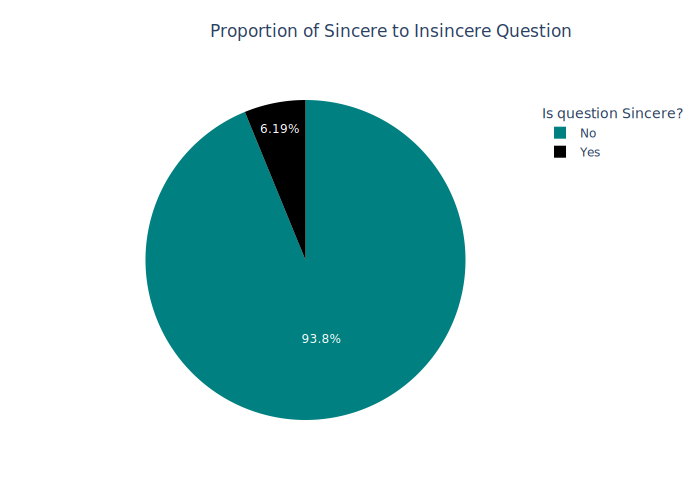

In [21]:
fig = px.pie(
    target_count, values=target_count.values, names=['No', 'Yes'],
    title='Proportion of Sincere to Insincere Question',
    color_discrete_sequence=plot_color,
)

fig.update_layout(legend_title_text='Insincere question?', title_x=0.3, title_y=0.95,)
fig.show('svg')

In [23]:
all_text = ' '.join(raw_df['question_text'])

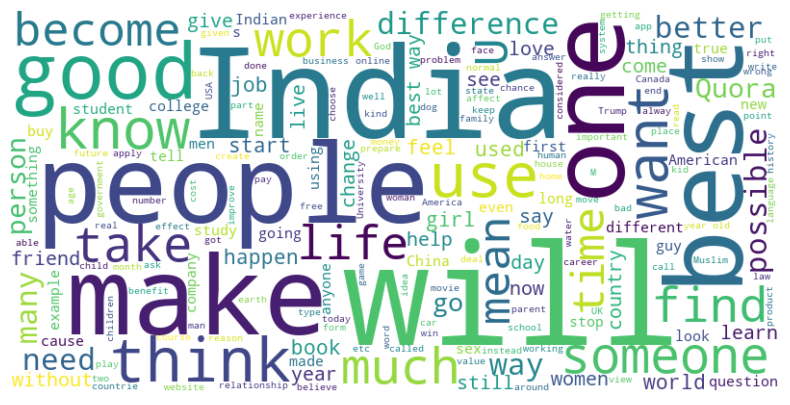

In [24]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Text Preprocessing 

In [27]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

In [69]:
def preprocess_question(question):
    # Tokenization
    tokens = word_tokenize(question)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)  

In [70]:
question = sample_df.question_text.values[:10][3]
question

'How do I download free APK Minecraft: Pocket Edition for iOS (iPhone)?'

In [71]:
preprocess_question(question)

'download free apk minecraft pocket edit io iphon'

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [77]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_question, 
                             max_features=1000)

In [78]:
vectorizer.fit(sample_df.question_text)

TfidfVectorizer(max_features=1000,
                preprocessor=<function preprocess_question at 0x0000021183CB5000>)

In [79]:
len(vectorizer.vocabulary_)

1000

In [80]:
vectorizer.get_feature_names_out()[:100]

array(['10', '100', '11', '12', '12th', '15', '20', '2017', '2018', '30',
       'abl', 'abroad', 'abus', 'academ', 'accept', 'access',
       'accomplish', 'accord', 'account', 'achiev', 'act', 'action',
       'activ', 'actor', 'actual', 'ad', 'add', 'address', 'admiss',
       'adult', 'advanc', 'advantag', 'advic', 'affect', 'africa',
       'african', 'age', 'ago', 'agre', 'air', 'allow', 'almost', 'alon',
       'alreadi', 'also', 'altern', 'alway', 'amazon', 'america',
       'american', 'amount', 'analysi', 'ancient', 'android', 'anim',
       'anoth', 'answer', 'anxieti', 'anyon', 'anyth', 'apart', 'app',
       'appear', 'appl', 'appli', 'applic', 'approach', 'arab', 'area',
       'arm', 'armi', 'around', 'art', 'asian', 'ask', 'associ',
       'atheist', 'attack', 'attend', 'attract', 'australia', 'avail',
       'averag', 'avoid', 'away', 'babi', 'back', 'bad', 'ball', 'ban',
       'bangalor', 'bank', 'base', 'basic', 'beauti', 'becom', 'begin',
       'behind', 'believ',

In [81]:
inputs = vectorizer.transform(sample_df.question_text)

In [82]:
inputs.shape

(100100, 1000)

In [86]:
test_inputs = vectorizer.transform(test_df.question_text)

In [88]:
test_inputs.shape

(375806, 1000)

## Model Building

In [90]:
from sklearn.model_selection import train_test_split

In [92]:
X_train, X_val, y_train, y_val = train_test_split(inputs, sample_df.target, test_size=0.2, random_state=42)

In [96]:
print(f'Shape of training data: f{X_train.shape}')
print(f'Shape of val data: f{X_val.shape}')

Shape of training data: f(80080, 1000)
Shape of val data: f(20020, 1000)


In [93]:
from xgboost import XGBClassifier

In [94]:
model = XGBClassifier()

In [97]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [98]:
train_preds = model.predict(y_train)
train_preds

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
pd.Series(y_train).value_counts()

0    75255
1     4825
Name: target, dtype: int64

## Evaluate Model

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [101]:
y_pred = model.predict(X_val)

In [102]:
pd.Series(y_pred).value_counts()

0    19578
1      442
dtype: int64

In [103]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

In [104]:
scores = [(recall, precision, f1, accuracy)]

metric = pd.DataFrame(scores, columns=['Recall','Precision','F1 Score', 'Accuracy'])
metric.insert(0, 'Model', 'XGBoost')
metric

,Model,Recall,Precision,F1 Score,Accuracy
0,XGBoost,0.231908,0.638009,0.340169,0.945355


## Make Predictions on Test Data

In [183]:
# Re-train model on all dataset
model = XGBClassifier(random_state=42)
model.fit(inputs, sample_df.target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [184]:
test_preds = model.predict(test_inputs)

In [185]:
test_preds

array([0, 0, 0, ..., 0, 0, 0])

In [186]:
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [187]:
assert test_preds.shape[0] == sub_df.shape[0]

In [188]:
sub_df.prediction = test_preds

In [189]:
sub_df.to_csv('submission.csv', index=None)

## Save Model

In [115]:
import joblib

In [190]:
single_input = pd.DataFrame([{'question_text': 'Why do so many people on this damn site not ac...'}])
single_input

,question_text
0,Why do so many people on this damn site not ac...


In [191]:
user_input = vectorizer.transform(single_input.question_text)

In [192]:
model.predict(user_input)

array([0])

In [193]:
mapping = {
    'vectorizer': vectorizer,
    'model': model
}

In [194]:
joblib.dump(mapping, 'model.joblib')

['model.joblib']